In [2]:
# RUN ALL

import cv2
from skimage.morphology import skeletonize
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import math
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fmg
import os
import networkx as nx

method = 1
part1 = 1

def intersection_area(contour, region):
    x1, y1, x2, y2 = region
    
    # Create an image filled with zeros, and an image filled with ones in the shape of the contour
    mask = cv2.fillPoly(np.zeros((y2-y1, x2-x1)), [contour - [x1, y1]], 255).astype(np.uint8)
    
    # Calculate area by counting non-zero pixels
    area = cv2.countNonZero(mask)
    return area

def select_contours(contours, region):

    # Calculate intersection area for each contour and pair with contour
    contours_with_area = [(contour, intersection_area(contour, region)) for contour in contours]
    
    # Filter and sort by intersection area
    selected_contours = [contour for contour, area in contours_with_area if area > 0]
    selected_contours.sort(key=lambda contour: intersection_area(contour, region), reverse=True)
    
    return selected_contours

def calculate_angle(c1, c2, x, y):
    dy = y - c2
    dx = x - c1
    return math.atan2(dy, dx)

def residuals(params, points):
    c1, c2, r = params
    x, y = points.T
    return np.sqrt((x - c1)**2 + (y - c2)**2) - r

def fit_circle(points):
    x, y = points.T
    params_initial = (np.mean(x), np.mean(y), np.mean(np.sqrt((x - np.mean(x))**2 + (y - np.mean(y))**2)))
    res = least_squares(residuals, params_initial, args=(points,))
    c1, c2, r = res.x
    return c1, c2, r

import numpy as np

def circular_kernel(radius, diameter=None):
    if diameter is None:
        diameter = 2*radius + 1  
    y, x = np.ogrid[-radius:diameter-radius, -radius:diameter-radius]
    mask = x**2 + y**2 <= radius**2
    kernel = np.zeros((diameter, diameter), dtype=np.uint8)  # Ensuring type uint8
    kernel[mask] = 1
    return kernel

def get_adjacent_nodes(node, shape):
    adjacent_nodes = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                continue
            r, c = node[0] + i, node[1] + j
            if r >= 0 and r < shape[0] and c >= 0 and c < shape[1]:
                adjacent_nodes.append((r, c))
    return adjacent_nodes

# Load the video
name = 'PXL_20231003_074535766.TS'
#video_path = r'\\home.org.aalto.fi\silvap1\data\Desktop\RODS\Recordings' + '\\' + name + '.mp4'
#dir_path = r'\\home.org.aalto.fi\silvap1\data\Documents\InfraTec\IRB2ASCII' # CHANGE THIS FOLDER
video_path = r'/scratch/work/silvap1/zahra' + '/' + name + '.mp4'
dir_path = r'/scratch/work/silvap1/temp'

dpi=300
video = cv2.VideoCapture(video_path)

y_start, y_end = 300, 900  # Replace with your actual y coordinates
#x_start, x_end = 850, 1450  # Replace with your actual x coordinates
x_start, x_end = 700, 1300  # Replace with your actual x coordinates


# Get the frames per second (fps) of the video
fps = 6#math.ceil(video.get(cv2.CAP_PROP_FPS))
print("Extracting Circle")

# Loop through all frames in the video
if 1 == 1:
    TOT = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    vx = np.zeros(int(TOT/fps)+1)
    vy = np.zeros(int(TOT/fps)+1)
    time = np.zeros(int(TOT/fps)+1)
    for k in range(TOT):
        ret, frame = video.read()
        if not ret:
            break  # Break the loop if we are at the end of the video
    
        # Process every [fps] frames, i.e., every second
        if k % fps == 0:
            
            time[int(k/fps)] = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
            frame_c = frame[y_start:y_end, x_start:x_end]
            c_frame = cv2.cvtColor(frame_c, cv2.COLOR_BGR2LAB)
            
            # Calculate angular speed
            l_channel = cv2.cvtColor(frame_c, cv2.COLOR_BGR2HSV)[:,:,1]
            _, th = cv2.threshold(l_channel, 50, 255, cv2.THRESH_BINARY)
            
            cv2.circle(th, (290, 300), 110, (0, 0, 0), thickness=-1)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
            dil1 = cv2.dilate(th, kernel, iterations = 1)
            th = cv2.erode(dil1, kernel, iterations = 1)
            contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            largest_contour = max(contours, key=cv2.contourArea)
            moments = cv2.moments(largest_contour)
            vx[int(k/fps)] = int(moments['m10'] / moments['m00'])
            vy[int(k/fps)] = int(moments['m01'] / moments['m00'])
            
            if k < 0:
                fig, ax = plt.subplots(dpi=150)
                #ax.imshow(cv2.cvtColor(frame_c, cv2.COLOR_BGR2RGB))
                ax.imshow(th, cmap='gray')
                #grid_size=20
                for i in range(len(largest_contour)):
                    plt.plot(largest_contour[i][0][0],largest_contour[i][0][1],'y.', markersize=1)
                #for i in range(0, 1080, grid_size):
                 #   ax.axvline(x=i, color='w', linestyle='-', linewidth=.25)
                #for j in range(0, 1920, grid_size):
                 #   ax.axhline(y=j, color='w', linestyle='-', linewidth=.25)
                ax.plot(vx[int(k/fps)], vy[int(k/fps)], 'rx')
                #ax.set_xlim((0,400))
                #ax.set_ylim((0,400))

    points = np.array([(xi, yi) for xi, yi in zip(vx, vy)])
    c1, c2, r = fit_circle(points)
    
    angles_radians = [calculate_angle(c1, c2, x, y) for x, y in points]
    angles_degrees = [math.degrees(theta) for theta in angles_radians]
    
    df_angle = np.diff(angles_degrees)
    df_angle[abs(df_angle > 100)] -= 360  
    
    #fig, ax = plt.subplots(dpi=150)
    #circle = plt.Circle((c1, c2), r, color='green', fill=False, linewidth=6)
    #ax.add_patch(circle)
    #ax.plot(points[:,0], points[:,1], 'r.',alpha=0.5)
    #ax.plot(c1, c2, 'kx')
    #ax.axis('equal')
    #ax.set_xlim((100,500))
    #ax.set_ylim((100,500))
    #stop
video = cv2.VideoCapture(video_path)
print("Circle extracted")
# Get the frames per second (fps) of the video
fps = 6 #math.ceil(video.get(cv2.CAP_PROP_FPS))

# Loop through all frames in the video
#while True:
TOT = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
vx2 = np.zeros(int(TOT/fps)+1)
vy2 = np.zeros(int(TOT/fps)+1)
vx2b0 = np.zeros(int(TOT/fps)+1)
vy2b0 = np.zeros(int(TOT/fps)+1)
vx2b1 = np.zeros(int(TOT/fps)+1)
vy2b1 = np.zeros(int(TOT/fps)+1)

vx3 = np.zeros(int(TOT/fps)+1)
vy3 = np.zeros(int(TOT/fps)+1)
time2 = np.zeros(int(TOT/fps)+1)
npoints = np.zeros(int(TOT/fps)+1)
inters = []
fsize = 40
for k in range(TOT):
    ret, frame = video.read()
    if not ret:
        break  # Break the loop if we are at the end of the video

    # Process every [fps] frames, i.e., every second
    if k % fps == 0:
        
        time2[int(k/fps)] = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
        frame_c = frame[y_start:y_end, x_start:x_end]
        l_channel = cv2.cvtColor(frame_c, cv2.COLOR_BGR2GRAY)
        
        if method > 0:
            _, th = cv2.threshold(l_channel, 50, 255, cv2.THRESH_BINARY_INV)
            
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
            er1 = cv2.erode(th, kernel, iterations = 2)
            dil1 = cv2.dilate(er1, kernel, iterations = 2)
            kernel = circular_kernel(101)
            dil2 = cv2.dilate(dil1, kernel, iterations = 1)
            er2 = cv2.erode(dil2, kernel, iterations = 1)
            th = er2
            
            contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 200 and not cv2.pointPolygonTest(cnt, (0, 0), False) == 1]
            largest_contour = max(filtered_contours, key=cv2.contourArea)
            
            # Skeletonization
            binary_mask = np.zeros_like(frame_c, dtype=np.uint8) # Create an empty image to fill the contour
            cv2.drawContours(binary_mask, filtered_contours, -1, (255, 255, 255), thickness=cv2.FILLED) # Fill the contour to create a binary mask
            binary_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY) # Convert to grayscale and binary
            _, binary_mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
            #skeleton = skeletonize(binary_mask // 255)
            skeleton = skeletonize(binary_mask // 255, method='lee').astype(np.uint8) #img_as_ubyte(skeleton, method = 'lee')
            
            # Create a graph from the skeleton
            graph = nx.Graph()
            for index in np.ndindex(skeleton.shape):
                if skeleton[index]:
                    graph.add_node(index) 
            for node in graph.nodes:
                for neighbor in get_adjacent_nodes(node, skeleton.shape):
                    if skeleton[neighbor]:
                        graph.add_edge(node, neighbor)
            (vx2b0[int(k/fps)], vy2b0[int(k/fps)]), (vx2b1[int(k/fps)], vy2b1[int(k/fps)]) = list(graph.nodes)[0], list(graph.nodes)[-1]
            
            if k < -300:
                fig, ax = plt.subplots(dpi=150)
                ax.imshow(cv2.cvtColor(frame_c, cv2.COLOR_BGR2RGB))
                ax.imshow(skeleton, cmap='gray', alpha = 0.25)
                
                for i in range(len(largest_contour)):
                    plt.plot(largest_contour[i][0][0],largest_contour[i][0][1],'y.', markersize=1)
                ax.plot(vy2b1[int(k/fps)], vx2b1[int(k/fps)], 'rx')
            # Fit ellipse
            if 1==1:
                ellipse = cv2.fitEllipse(largest_contour)
                scaled = tuple(x * 0.5 for x in ellipse[1])
                ellipse = (ellipse[0], scaled) + ellipse[2:]
                ellipse_img = np.zeros_like(skeleton)
                cv2.ellipse(ellipse_img, ellipse, 255, -1)  # -1 fills the ellipse
                intersection = cv2.bitwise_and(ellipse_img, skeleton)
                
                # Linear regression
                y_sk, x_sk = np.where(intersection > 0)
                npoints[int(k/fps)] = len(y_sk)
                xreg = x_sk.reshape(-1, 1)
                yreg = y_sk.reshape(-1, 1)
                sk = np.array([(xi, yi) for xi, yi in zip(x_sk, y_sk)]).reshape((-1,1,2))#
                model = LinearRegression().fit(xreg, yreg)
                m = model.coef_[0]
                b = model.intercept_
                
                minx = np.min(largest_contour[:,:,0])
                maxx = np.max(largest_contour[:,:,0])
                intersections = []
                for q1 in range(minx, maxx + 1):
                    q2 = m[0] * q1 + b[0]
                    if cv2.pointPolygonTest(largest_contour, (q1, q2), False) >= 0:
                        intersections.append((q1, q2))
                
                if len(intersections) > 2:
                    min_point = min(intersections, key=lambda t: t[0])  # Select point with min x
                    max_point = max(intersections, key=lambda t: t[0])  # Select point with max x
                    true_intersections = [min_point, max_point]
                else:
                    true_intersections = intersections
                    print(intersections, "need to solve this man")
                inters.append(true_intersections)
                # Calculate line endpoints
                x1p = 0
                y1p = int(b)
                x2p = intersection.shape[1]
                y2p = int(m * x2p + b)
                
                moments = cv2.moments(largest_contour)
                vx2[int(k/fps)] = int(moments['m10'] / moments['m00'])
                vy2[int(k/fps)] = int(moments['m01'] / moments['m00'])
                cv2.ellipse(frame_c, ellipse, (0,220,20), 1)
                cv2.line(frame_c, (x1p, y1p), (x2p, y2p), (255,255,255), 1)
                cv2.polylines(frame_c, sk, True, (60, 200, 20), 2)
            
            
        if method > 0:
            _, th = cv2.threshold(l_channel, 17, 255, cv2.THRESH_BINARY_INV)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
            er1 = cv2.erode(th, kernel, iterations = 2)
            dil1 = cv2.dilate(er1, kernel, iterations = 2)
            kernel = circular_kernel(101)
            dil2 = cv2.dilate(dil1, kernel, iterations = 1)
            er2 = cv2.erode(dil2, kernel, iterations = 1)
            th = dil1
            

            contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if len(contours) > 0:
                largest_contour = max(contours, key=cv2.contourArea)
                xc, yc, wc, hc = cv2.boundingRect(largest_contour)
            
            if len(contours)>0:
                moments = cv2.moments(contours[0])
                vx3[int(k/fps)] = int(moments['m10'] / moments['m00'])
                vy3[int(k/fps)] = int(moments['m01'] / moments['m00'])
            
            if k < -300:
                
                fig, ax = plt.subplots(dpi=150)
                ax.imshow(cv2.cvtColor(frame_c, cv2.COLOR_BGR2RGB))
                ax.imshow(th, cmap='gray',alpha=0.75)
                for i in range(len(contours[0])):
                    plt.plot(contours[0][i][0][0],contours[0][i][0][1],'y.', markersize=1)
                ax.plot(vx3[int(k/fps)], vy3[int(k/fps)], 'rx')
                
        if 1==1:
            fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')
            cv2.drawContours(frame_c, contours, -1, (60, 20, 220), 1)
            # Convert frames to RGB for visualization with matplotlib
            frame_rgb = cv2.cvtColor(frame_c, cv2.COLOR_BGR2RGB)
            ax.imshow(frame_rgb)
            ax.plot(vy2b1[int(k/fps)], vx2b1[int(k/fps)], 'rx')
            ax.axis('off')
            plt.tight_layout()
            plt.savefig(dir_path + '/' + str(k+1).zfill(5)+'.png', dpi=dpi, bbox_inches='tight',pad_inches=0)
            plt.close('all')
        

video_name = dir_path + '/' + 'video_' + name + '.avi'
images = sorted([img for img in os.listdir(dir_path) if img.endswith(".png")])
frame = cv2.imread(os.path.join(dir_path, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 10.0, (width,height))

for l in range(len(images)):
    video.write(cv2.imread(os.path.join(dir_path, images[l])))
    
cv2.destroyAllWindows()
video.release()
points2 = np.array([(xi, yi) for xi, yi in zip(vx2, vy2)])
angles_radians2 = [calculate_angle(c1, c2, x, y) for x, y in points2]
angles_degrees2 = [math.degrees(theta) for theta in angles_radians2]
np.savez(dir_path + '/' + name + '_measure.npz', vx=vx, vy=vy, time=time, vx2=vx2, vy2=vy2, vx3=vx3, vy3=vy3, 
         vx4a = vx2b0, vy4a = vy2b0, vx4b = vx2b1, vy4b = vy2b1, time2=time2, inters=inters, npoints=npoints)

Extracting Circle
Circle extracted
0
60
120
180
240
300
360
420
480
540
600
660
720
780
840
900
960
1020
1080
1140
1200
1260
1320
1380
1440
1500
1560
1620
1680
1740
1800
1860
1920
1980
2040
2100
2160
2220
2280
2340
2400
2460
2520
2580
2640
2700
2760
2820
2880
2940
3000
3060
3120
3180
3240
3300
3360
3420
3480
3540
3600
3660
3720
3780
3840
3900
3960
4020
4080
4140
4200


276.23339471227297 299.83651381722547 168.93065051823683


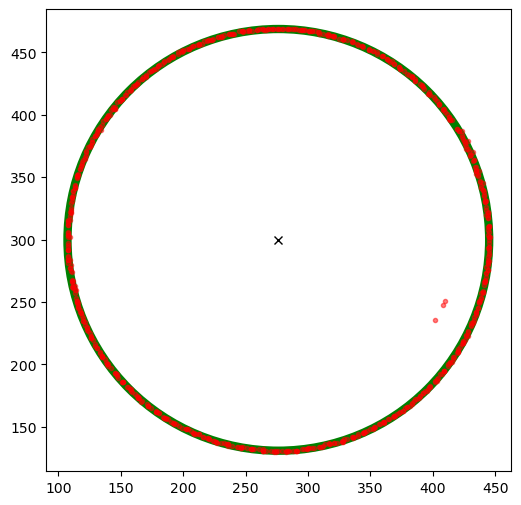

In [58]:
def residuals(params, points):
    c1, c2, r = params
    x, y = points.T
    return np.sqrt((x - c1)**2 + (y - c2)**2) - r

def fit_circle(points, threshold=None, exclude_outliers=True):
    x, y = points.T
    params_initial = (np.mean(x), np.mean(y), np.mean(np.sqrt((x - np.mean(x))**2 + (y - np.mean(y))**2)))
    res = least_squares(residuals, params_initial, args=(points,))
    c1, c2, r = res.x
    
    # Check if exclusion of outliers is requested
    if exclude_outliers and threshold is not None:
        # Calculate residuals for all points
        all_residuals = residuals(res.x, points)
        # Create a mask for points with residuals under the threshold
        mask = np.abs(all_residuals) < threshold
        # Refit the circle using only the inliers
        if np.any(mask):
            res = least_squares(residuals, params_initial, args=(points[mask],))
            c1, c2, r = res.x
    
    return c1, c2, r

points = np.array([(xi, yi) for xi, yi in zip(vx, vy)])

c1, c2, r = fit_circle(points, threshold=20.0)

plt.figure(figsize=(6,6))
plt.axis('equal')

# Draw the circle with a red border
circle = plt.Circle((c1, c2), r, color='green', fill=False, linewidth=6)
plt.gca().add_patch(circle)

print(c1,c2,r)

plt.plot(points[:,0], points[:,1], 'r.',alpha=0.5)
plt.plot(c1, c2, 'kx')
plt.axis('equal')
plt.show()

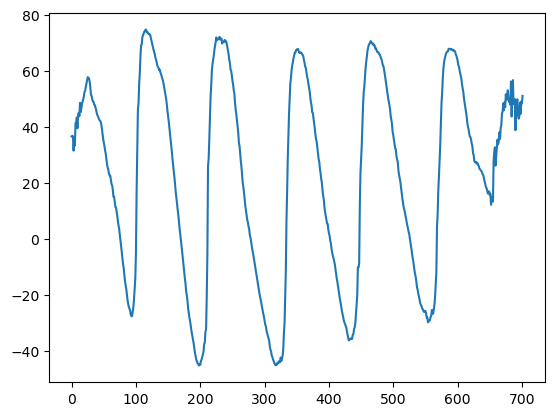

In [59]:
points = []
for k in range(len(inters)):
    if k == 0:
        p1 = inters[k][1][0]
        p2 = inters[k][1][1]
    else:
        dist1 = np.linalg.norm(np.array((p1,p2)) - np.array((inters[k][0][0],inters[k][0][1])))
        dist2 = np.linalg.norm(np.array((p1,p2)) - np.array((inters[k][1][0],inters[k][1][1])))
        if dist1 < dist2:
            p1 = inters[k][0][0]
            p2 = inters[k][0][1]
        else:
            p1 = inters[k][1][0]
            p2 = inters[k][1][1]
    points.append((p1, p2))
            
angles_radians = [calculate_angle(c1, c2, x, y) for x, y in points]
angles_degrees3 = [math.degrees(theta) for theta in angles_radians]

plt.plot(angles_degrees3)

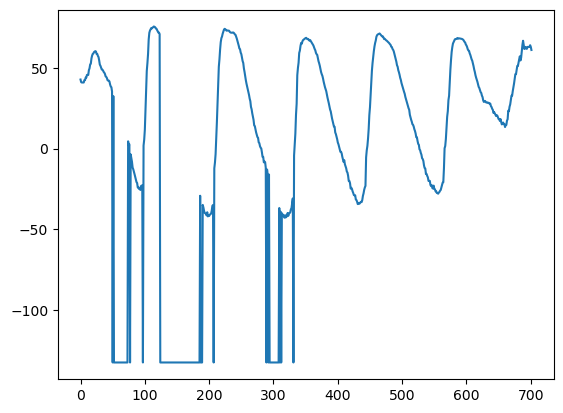

In [60]:
# Method 2
points = np.array([(xi, yi) for xi, yi in zip(vx3, vy3)])
angles_radians = [calculate_angle(c1, c2, x, y) for x, y in points]
angles_degrees1 = [math.degrees(theta) for theta in angles_radians]

plt.plot(angles_degrees1)

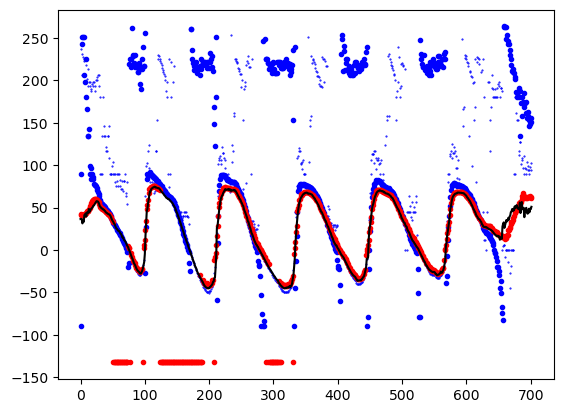

In [61]:
# Method 2
points = np.array([(xi, yi) for xi, yi in zip(vx2b1, vy2b1)])
for k in range(len(vx2b1)):
    x0, y0 = vx2b0[k], vy2b0[k]
    x1, y1 = vx2b1[k], vy2b1[k]
    if k == 0:
        xm, ym = (x0+x1)/2, (y0+y1)/2
    dist1 = np.linalg.norm(np.array((x0-xm,y0-ym)))
    dist2 = np.linalg.norm(np.array((x0-xm,y0-ym)))
    if 


angles_radians = [calculate_angle(vx2b1[0], vy2b1[0], x, y) for x, y in points]
angles_degrees2 = [math.degrees(theta) for theta in angles_radians]
points = np.array([(xi, yi) for xi, yi in zip(vx2b0, vy2b0)])
angles_radians = [calculate_angle(vx2b0[0], vy2b0[0], x, y) for x, y in points]
angles_degrees2b = [math.degrees(theta) for theta in angles_radians]

ang1 = angles_degrees1[0]
ang2 = angles_degrees2[0]
ang3 = angles_degrees3[0]

plt.plot(90-np.asarray(angles_degrees2),'b.')
plt.plot(90-np.asarray(angles_degrees2b),'b.',ms=1)
plt.plot(np.asarray(angles_degrees1),'r.')
plt.plot(np.asarray(angles_degrees3),'k')

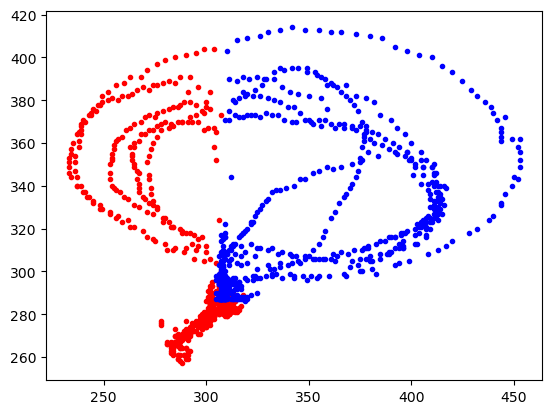

In [62]:
plt.plot(vx2b0, vy2b0, 'r.')
plt.plot(vx2b1, vy2b1, 'b.')